# Mapping the intertidal zone

<div class="admonition tip">
    <p class="admonition-title">More information</p>
    <p>
        For more information about the workflows described below, refer to <a href="https://www.sciencedirect.com/science/article/pii/S0034425717301591">Sagar et al. 2017</a>, <a href="https://www.mdpi.com/2072-4292/10/3/480">Sagar et al. 2018</a>, and <a href="https://www.sciencedirect.com/science/article/pii/S0272771418308783">Bishop-Taylor et al. 2019</a>.
    </p>
</div>

## Getting started
Import any Python packages we need for the analysis:

In [1]:
import odc.stac
import pystac_client
import planetary_computer
import matplotlib.pyplot as plt

from eo_tides.eo import tag_tides
from eo_tides.stats import tide_stats
from eo_tides.utils import list_models

from dep_tools import s2_utils
import geopandas as gpd
from shapely.geometry import box
import rioxarray
from dea_tools.dask import create_local_dask_cluster
import rasterio.features
import dep_tools.grids as grid

from pystac.extensions.projection import ProjectionExtension as proj
from pystac.extensions.item_assets import ItemAssetsExtension

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 12,Total memory: 13.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63279,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 13.21 GiB
Comm: tcp://127.0.0.1:63284,Total threads: 12
Dashboard: http://127.0.0.1:63285/status,Memory: 13.21 GiB
Nanny: tcp://127.0.0.1:63282,


### Tide model directory
We need to tell `eo-tides` the location of our tide model directory (if you haven't set this up, [refer to the setup instructions here](../../setup)):

In [3]:
directory = "tidal_models"

# Confirm we have model data
list_models(directory=directory, show_supported=False);

──────────────────────────────────────────────────────────────────────────────
 󠀠🌊  | Model                | Expected path                                   
──────────────────────────────────────────────────────────────────────────────
 ✅  │ FES2022              │ tidal_models/fes2022b/ocean_tide                
 ✅  │ FES2022_load         │ tidal_models/fes2022b/load_tide                 
──────────────────────────────────────────────────────────────────────────────

Summary:
Available models: 2/51


### Analysis parameters
To make our analysis more re-usable, we can define some important parameters up-front.
The default will load **Landsat 8 and 9** satellite data from **2022-23** over the city of **Broome, Western Australia** - a macrotidal region with extensive intertidal coastal habitats.

<div class="admonition tip">
    <p class="admonition-title">Tip</p>
    <p>
        Leave the defaults below unchanged the first time you run through this notebook.
    </p>
</div>

In [4]:
# Set the study area (xmin, ymin, xmax, ymax)
# bounds for Samoa
# bbox = [-172.8, -13.8, -172.1, -13.37]

grid_p = grid.gadm()
country_code = "NIU"
aoi = grid_p[grid_p["GID_0"] == country_code]
aoi = aoi['geometry'].buffer(0.003) #tweak

#load coral coast
import geopandas as gpd
#aoi = gpd.read_file("coral_coast.geojson")

bbox = rasterio.features.bounds(aoi)

# Set the time period
year = "2022/2023"

cloud_cover = 40
resolution = 10

# Set the number of tide intervals. More intervals can produce more detail, but add noise
tide_intervals = 5

# Satellite products and bands to load
bands = ["green", "nir", "scl"]

# Tide model to use
tide_model = "FES2022"

#aoi.explore()

## Load satellite data using odc-stac

Now we can load a time-series of satellite data over our area of interest using the Open Data Cube's `odc-stac` package.
This powerful package allows us to load open satellite data (e.g ESA Sentinel-2 or NASA/USGS Landsat) for any time period and location on the planet, and load our data into a multi-dimensional `xarray.Dataset` format dataset.

In this example, we will load our data from the [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) STAC catalogue, and restrict our data to cloud-free images with less than 10% cloud (`eo:cloud_cover": {"lt": 10}"`), and load our data at low resolution (`resolution=50`) to improve load times.

<div class="admonition tip">
    <p class="admonition-title">Tip</p>
    <p>
        For a more detailed guide to using STAC metadata and <code>odc-stac</code> to find and load satellite data, refer to this <a href="https://knowledge.dea.ga.gov.au/guides/setup/gis/stac/">STAC user guide</a>.
    </p>
</div>

In [5]:
# Connect to STAC catalog
catalog = pystac_client.Client.open("https://earth-search.aws.element84.com/v1")
    
# Set cloud access defaults
odc.stac.configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
)

# Build a query and search the STAC catalog for all matching items
query = catalog.search(
    bbox=bbox,
    collections="sentinel-2-c1-l2a",
    datetime=f"{year}",
    query={
        "eo:cloud_cover": {"lt": cloud_cover},  # Filter to images with <5% cloud
     },
)

items = query.item_collection()
#epsg = proj.ext(items[0]).epsg
#print(epsg)

# Load data into xarray format
ds = odc.stac.load(
    items=items,
    bands=bands,
    crs="utm",
    resolution=resolution,
    chunks={"x": 2048, "y": 2048},
    groupby="solar_day",
    #resampling={"qa_pixel": "nearest", "SCL": "nearest", "*": "cubic"},
    bbox=bbox,
    fail_on_error=False,
)

#import stackstac
#ds = stackstac.stack(items, bounds_latlon=bbox, assets=bands, chunksize=4096, resolution=10)

# Apply USGS Landsat Collection 2 scaling factors to convert
# surface reflectance to between 0.0 and 1.0. See:
# https://www.usgs.gov/faqs/how-do-i-use-a-scale-factor-landsat-level-2-science-products
#ds = (ds.where(ds != 0) * 0.0000275 + -0.2).clip(0, 1)

ds

<xarray.Dataset> Size: 1GB
Dimensions:      (y: 2337, x: 1945, time: 45)
Coordinates:
  * y            (y) float64 19kB 7.904e+06 7.904e+06 ... 7.881e+06 7.881e+06
  * x            (x) float64 16kB 6.1e+05 6.1e+05 ... 6.294e+05 6.294e+05
    spatial_ref  int32 4B 32702
  * time         (time) datetime64[ns] 360B 2022-12-12T21:40:49.628000 ... 20...
Data variables:
    green        (time, y, x) uint16 409MB dask.array<chunksize=(1, 2048, 1945), meta=np.ndarray>
    nir          (time, y, x) uint16 409MB dask.array<chunksize=(1, 2048, 1945), meta=np.ndarray>
    scl          (time, y, x) uint8 205MB dask.array<chunksize=(1, 2048, 1945), meta=np.ndarray>

In [6]:
raster_properties = items[0].assets['red'].to_dict()['raster:bands'][0]
raster_properties

{'nodata': 0,
 'data_type': 'uint16',
 'spatial_resolution': 10,
 'scale': 0.0001,
 'offset': -0.1}

In [7]:
#cloud mask
ds = s2_utils.mask_clouds(ds)
ds = s2_utils.harmonize_to_old(ds)
ds

<xarray.Dataset> Size: 2GB
Dimensions:      (time: 45, y: 2337, x: 1945)
Coordinates:
  * y            (y) float64 19kB 7.904e+06 7.904e+06 ... 7.881e+06 7.881e+06
  * x            (x) float64 16kB 6.1e+05 6.1e+05 ... 6.294e+05 6.294e+05
    spatial_ref  int32 4B 32702
  * time         (time) datetime64[ns] 360B 2022-12-12T21:40:49.628000 ... 20...
Data variables:
    green        (time, y, x) float32 818MB dask.array<chunksize=(1, 2048, 1945), meta=np.ndarray>
    nir          (time, y, x) float32 818MB dask.array<chunksize=(1, 2048, 1945), meta=np.ndarray>
    scl          (time, y, x) float32 818MB dask.array<chunksize=(1, 2048, 1945), meta=np.ndarray>

In [8]:
#scale and offset
ds = ((ds * raster_properties["scale"]) + raster_properties["offset"]).clip(min=0)

In [9]:
#coastal buffer
buffer = gpd.read_file("../grid/buffered_coastline_grid.gpkg")
ds = ds.rio.clip(buffer.geometry.values, buffer.crs, drop=False, invert=False)
#aoi buffer
ds = ds.rio.clip(aoi.geometry.values, aoi.crs, drop=False, invert=False)

### Converting satellite data to NDWI water index

To help us map the distribution of tidal inundation across our study area, we can convert our spectral bands to a remote sensing water index that enhances contrast between water and dry land. 
We will use the **Normalised Difference Water Index (NDWI)**, which is particularly useful for intertidal mapping as it is [less vulnerable to misclassifications caused by wet sand and mud after high tide](https://www.sciencedirect.com/science/article/pii/S0272771418308783#sec2):

$$
\text{NDWI} = \frac{\text{Green} - \text{NIR}}{\text{Green} + \text{NIR}}
$$

In the image below, <span style="color:red">red</span> pixels represent dry land pixels, while <span style="color:blue">blue</span> pixels represent water:

In [10]:
# Calculate NDWI
ds[["ndwi"]] = (ds.green - ds.nir) / (ds.green + ds.nir) 

# Plot a single timestep
#ds.ndwi.isel(time=1).odc.explore(vmin=-0.5, vmax=0.5, cmap="RdBu")

## Modelling tide heights for each satellite image

We can now use the `tag_tides` function to [model tides for each image in our satellite timeseries](../Satellite_data):

In [11]:
ds["tide_height"] = tag_tides(
    data=ds,
    model=tide_model,
    directory=directory,
)

Setting tide modelling location from dataset centroid: -169.86, -19.05
Modelling tides with FES2022


We can plot a histogram of the tide heights of our satellite images. 
This shows that we have decent coverage of the tide range between approximately **-2.8 to 3.5 m Above Mean Sea Level (AMSL)**:

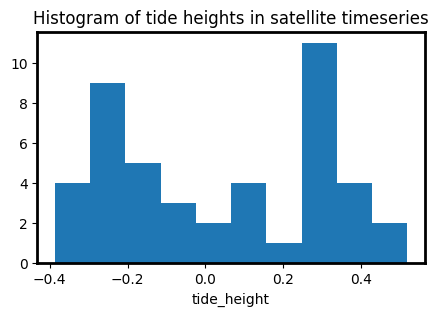

In [12]:
ds["tide_height"].plot.hist(bins=10, figsize=(5, 3))
plt.title("Histogram of tide heights in satellite timeseries");

### Exploring tide biases

It is also important to [compare our satellite tide observations against the full range of astronomical tides](../Tide_statistics) at our location.
This lets us become aware of any major biases in our data.
For example, here we can see that our data is biased away from low tide observations.
This means that our final intertidal maps will underestimate the lower extent of the intertidal zone.

Using tide modelling location: -169.86, -19.05
Modelling tides with FES2022
Using tide modelling location: -169.86, -19.05
Modelling tides with FES2022


🌊 Modelled astronomical tide range: 1.18 m (-0.58 to 0.60 m).
🛰️ Observed tide range: 0.90 m (-0.39 to 0.52 m).

🟡 77% of the modelled astronomical tide range was observed at this location.
🟢 The highest 7% (0.08 m) of the tide range was never observed.
🟡 The lowest 16% (0.19 m) of the tide range was never observed.

🌊 Mean modelled astronomical tide height: -0.00 m.
🛰️ Mean observed tide height: 0.04 m.
⬆️ The mean observed tide height was 0.04 m higher than the mean modelled astronomical tide height.


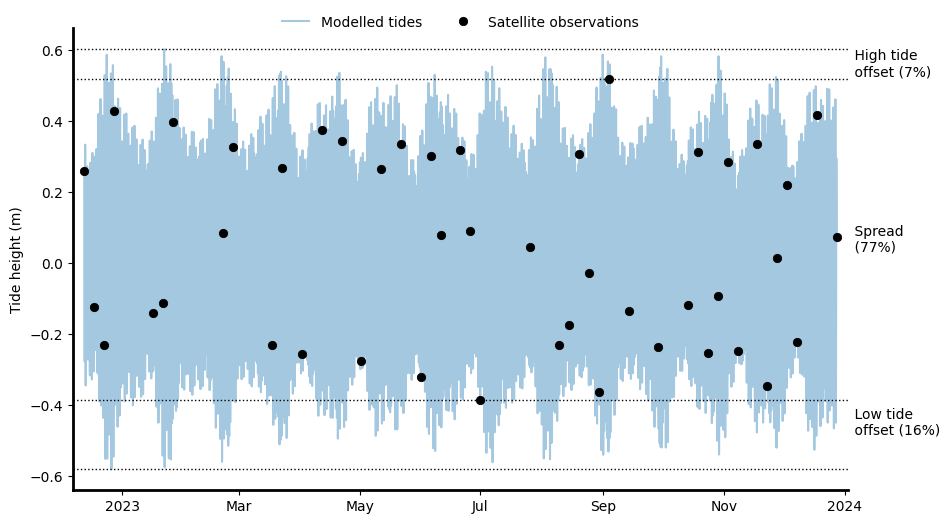

In [13]:
tide_stats(
    data=ds,
    model=tide_model,
    directory=directory,
);

## Extracting low and high tide images

Now that we have satellite images and associated tide heights, we can filter our data to extract only images from specific tidal stages.

In this example, we will focus on extracting **low tide** and **high tide** images.
We can identify low and high tide images by calculating quantiles of tide heights across time, selecting images from the lowest and highest 20% of tide heights.

<div class="admonition tip">
    <p class="admonition-title">Tip</p>
    <p>
        Try modifying the <code>lowtide_cutoff</code> and <code>hightide_cutoff</code> tide cutoffs below to customise the tidal stages we will analyse.
    </p>
</div>

In [14]:
# Calculate low and high tide height thresholds
lowtide_cutoff = 0.2
hightide_cutoff = 0.8
lowtide_thresh, hightide_thresh = ds.tide_height.quantile([lowtide_cutoff, hightide_cutoff])
print(f"Low tide threshold: {lowtide_thresh:.2f} metres AMSL")
print(f"High tide threshold: {hightide_thresh:.2f} metres AMSL")

Low tide threshold: -0.23 metres AMSL
High tide threshold: 0.32 metres AMSL


We can now use these thresholds to select just the subset of our data with tide heights lower and higher than our thresholds:

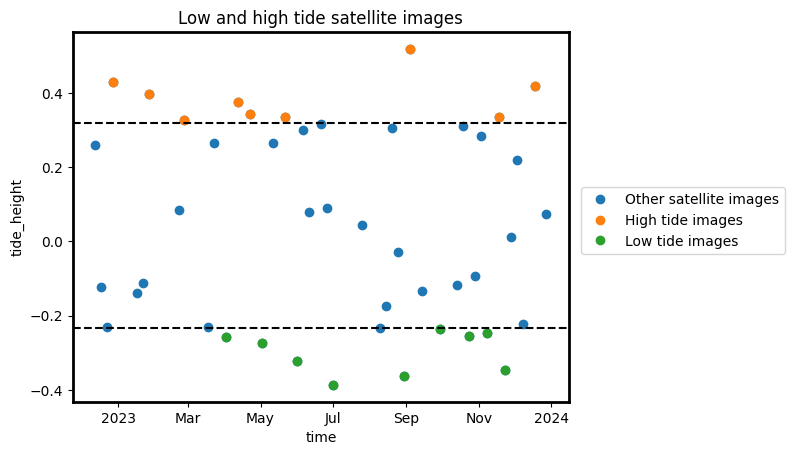

In [15]:
# Extract subset of low and high tide images
ds_lowtide = ds.sel(time=ds.tide_height <= lowtide_thresh)
ds_hightide = ds.sel(time=ds.tide_height >= hightide_thresh)

# Plot extracted images over all images
ds.tide_height.plot(marker="o", linewidth=0, label="Other satellite images")
ds_hightide.tide_height.plot(marker="o", linewidth=0, label="High tide images")
ds_lowtide.tide_height.plot(marker="o", linewidth=0, label="Low tide images")
plt.axhline(lowtide_thresh, color="black", linestyle="dashed")
plt.axhline(hightide_thresh, color="black", linestyle="dashed")
plt.legend(bbox_to_anchor=(1.01, 0.6))
plt.title("Low and high tide satellite images");

## Creating low and high tide NDWI composites

Individual satellite images can be affected by many sources of noise, including clouds, saltspray, whitewater and sunglint.
These sources of noise can make it difficult to map coastal environments consistently across time and along the coastline.

To produce consistent analysis outputs, it can be useful to combine multiple satellite images into a single, cleaner **"composite"** image.
This can improve the signal-to-noise ratio of our data, and allow us to map coastal features and change more accurately (at the cost of lower temporal resolution).

In this example, we will combine our low and high tide NDWI data into two **clean, relatively noise-free low tide and high tide median composites**. We use a median calculation for this analysis as medians are extremely robust to noisy data.



<div class="admonition important">
    <p class="admonition-title">Important</p>
    <p>
        Note the use of <code>.load()</code> below. Up to this point, our entire analysis has been "lazy", which means we haven't loaded the majority of our satellite data - we have simply "queued" up our analysis to run in a single step. This makes it quick and easy to write code without having to wait for every step of our workflow to run every time, or ever worrying about running out of memory. Running <code>.load()</code> triggers our entire analysis to run, and then load our final outputs into memory for further use. For more information about lazy loading and processing, see <a href="https://knowledge.dea.ga.gov.au/notebooks/Beginners_guide/09_Parallel_processing_with_Dask/">Parallel processing with Dask</a>.
    </p>
</div>

<div class="admonition important">
    <p class="admonition-title">Important</p>
    <p>
        Be patient; this step may take several minutes to complete.
    </p>
</div>

In [16]:
# Combine NDWI into single median composites
ndwi_lowtide_median = ds_lowtide.ndwi.median(dim="time")
ndwi_hightide_median = ds_hightide.ndwi.median(dim="time")

# Process our data and load into memory
ndwi_lowtide_median.load()
ndwi_hightide_median.load()

<xarray.DataArray 'ndwi' (y: 2337, x: 1945)> Size: 18MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * y            (y) float64 19kB 7.904e+06 7.904e+06 ... 7.881e+06 7.881e+06
  * x            (x) float64 16kB 6.1e+05 6.1e+05 ... 6.294e+05 6.294e+05
    spatial_ref  int64 8B 0
    tide_model   <U7 28B 'FES2022'
    quantile     float64 8B 0.8

Now that we have processed our median NDWI composites, we can plot them on a map:

In [17]:
#ndwi_lowtide_median.odc.explore(vmin=-0.5, vmax=0.5, cmap="RdBu")

In [18]:
#ndwi_hightide_median.odc.explore(vmin=-0.5, vmax=0.5, cmap="RdBu")

Or plot them together for a direct comparison.
We can see that the low tide NDWI composite contains additional exposed intertidal terrain along the coastline that becomes inundated at high tide:

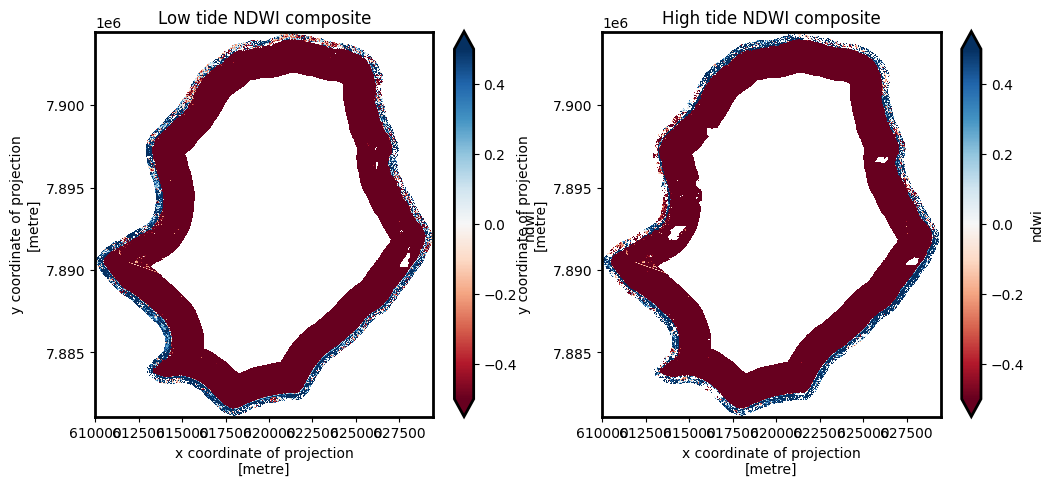

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ndwi_lowtide_median.plot.imshow(ax=axes[0], vmin=-0.5, vmax=0.5, cmap="RdBu")
ndwi_hightide_median.plot.imshow(ax=axes[1], vmin=-0.5, vmax=0.5, cmap="RdBu")
axes[0].set_title("Low tide NDWI composite")
axes[1].set_title("High tide NDWI composite");

## Mapping intertidal extent

We can now perform a simple comparison of our two outputs to identify intertidal pixels as any pixels that are **dry in our low tide composite**, but **wet in our high tide composite**.

First, let's classify our NDWI outputs into binary **dry (True or 1.0)** vs. **wet (False or 0.0)** using a standard 0.0 NDWI threshold.
In the images below, yellow pixels represent water, and purple pixels represent land:

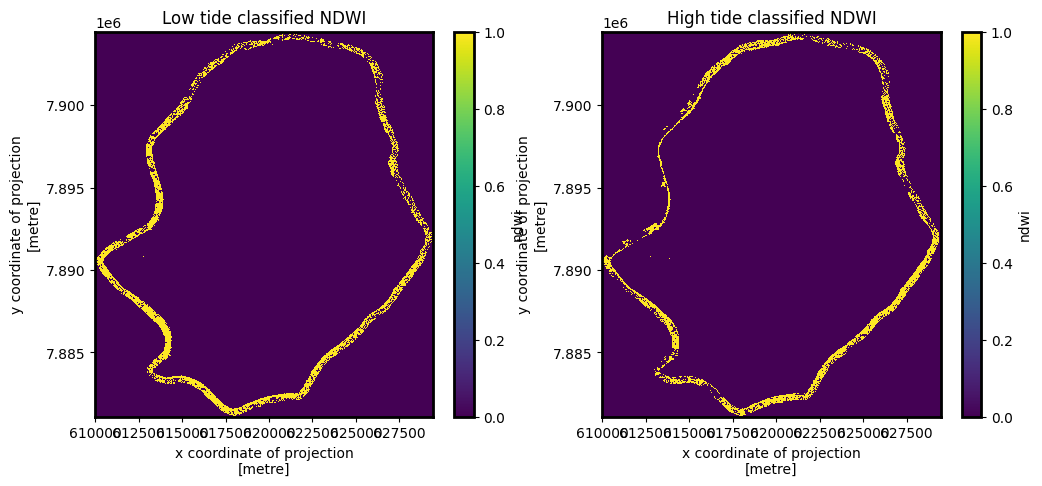

In [20]:
# Classify our NDWI layers
ndwi_lowtide_bool = ndwi_lowtide_median > 0.0
ndwi_hightide_bool = ndwi_hightide_median > 0.0

# Plot outputs
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ndwi_lowtide_bool.plot.imshow(ax=axes[0])
ndwi_hightide_bool.plot.imshow(ax=axes[1])
axes[0].set_title("Low tide classified NDWI")
axes[1].set_title("High tide classified NDWI");

Now, we can identify pixels that are `True` (dry) in our low tide data, and `False` (wet) in our high tide data.
Yellow pixels in our resulting map represent likely intertidal pixels that are exposed at low tide and inundated at high tide!

In [21]:
intertidal = ~ndwi_lowtide_bool & ndwi_hightide_bool
#intertidal.odc.explore()

### Elevation

In [22]:
#intertidal.astype("int16").odc.write_cog("intertidal_map.tif", overwrite=True);

In [23]:
from dea_tools.datahandling import load_ard, mostcommon_crs
from dea_tools.plotting import rgb, display_map
from dea_tools.bandindices import calculate_indices
from dea_tools.spatial import subpixel_contours, extract_vertices, xr_interpolate
from dea_tools.coastal import tidal_tag

In [24]:
ds = ds.drop_vars("scl")
ds

<xarray.Dataset> Size: 2GB
Dimensions:      (y: 2337, x: 1945, time: 45)
Coordinates:
  * y            (y) float64 19kB 7.904e+06 7.904e+06 ... 7.881e+06 7.881e+06
  * x            (x) float64 16kB 6.1e+05 6.1e+05 ... 6.294e+05 6.294e+05
  * time         (time) datetime64[ns] 360B 2022-12-12T21:40:49.628000 ... 20...
    spatial_ref  int64 8B 0
    tide_model   <U7 28B 'FES2022'
Data variables:
    green        (time, y, x) float32 818MB dask.array<chunksize=(1, 2048, 1945), meta=np.ndarray>
    nir          (time, y, x) float32 818MB dask.array<chunksize=(1, 2048, 1945), meta=np.ndarray>
    ndwi         (time, y, x) float32 818MB dask.array<chunksize=(1, 2048, 1945), meta=np.ndarray>
    tide_height  (time) float32 180B 0.2587 -0.1236 -0.2315 ... 0.4176 0.07386

In [25]:
import numpy as np
import pandas as pd
import xarray as xr

## Calculate tides for each timestep in the satellite dataset

#landsat_ds = tidal_tag(ds=landsat_ds, tidepost_lat=None, tidepost_lon=None)
#ds["tide_height"] = tag_tides(data=ds, model=tide_model, directory=directory)

# Bin tide heights into tidal intervals from low to high tide
binInterval = np.linspace(
    ds.tide_height.min().to_numpy(), ds.tide_height.max().to_numpy(), num=tide_intervals + 1
)
tide_intervals = pd.cut(
    ds.tide_height,
    bins=binInterval,
    labels=range(1, tide_intervals + 1),
    include_lowest=True,
)

# Add interval to dataset
ds["tide_interval"] = xr.DataArray(tide_intervals, coords=[ds.time])

ds


<xarray.Dataset> Size: 2GB
Dimensions:        (y: 2337, x: 1945, time: 45)
Coordinates:
  * y              (y) float64 19kB 7.904e+06 7.904e+06 ... 7.881e+06 7.881e+06
  * x              (x) float64 16kB 6.1e+05 6.1e+05 ... 6.294e+05 6.294e+05
  * time           (time) datetime64[ns] 360B 2022-12-12T21:40:49.628000 ... ...
    spatial_ref    int64 8B 0
    tide_model     <U7 28B 'FES2022'
Data variables:
    green          (time, y, x) float32 818MB dask.array<chunksize=(1, 2048, 1945), meta=np.ndarray>
    nir            (time, y, x) float32 818MB dask.array<chunksize=(1, 2048, 1945), meta=np.ndarray>
    ndwi           (time, y, x) float32 818MB dask.array<chunksize=(1, 2048, 1945), meta=np.ndarray>
    tide_height    (time) float32 180B 0.2587 -0.1236 -0.2315 ... 0.4176 0.07386
    tide_interval  (time) category 85B <class 'xarray.core.extension_array.Pa...

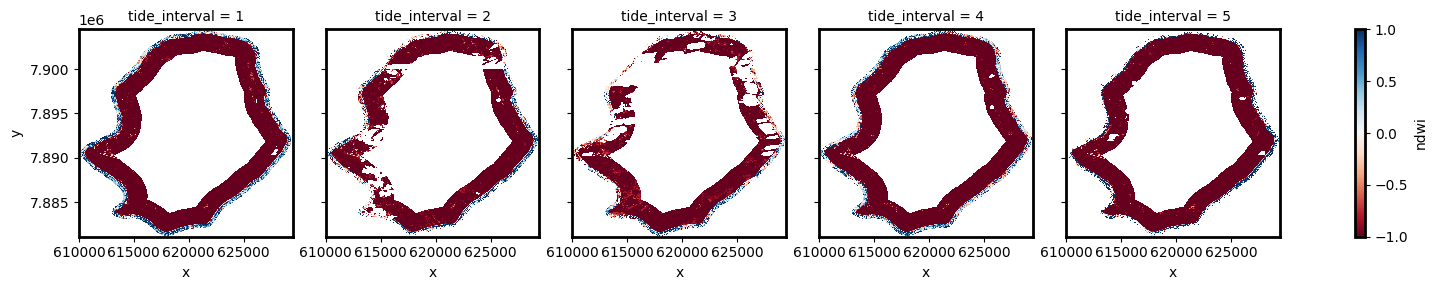

In [26]:
ds_intervals = (
    ds[["tide_interval", "ndwi", "tide_height"]]
    .groupby("tide_interval")
    .median(dim="time")
    .compute()
)

# Plot the resulting set of tidal intervals
ds_intervals.ndwi.plot(col="tide_interval", col_wrap=5, cmap="RdBu")

Operating in single z-value, multiple arrays mode


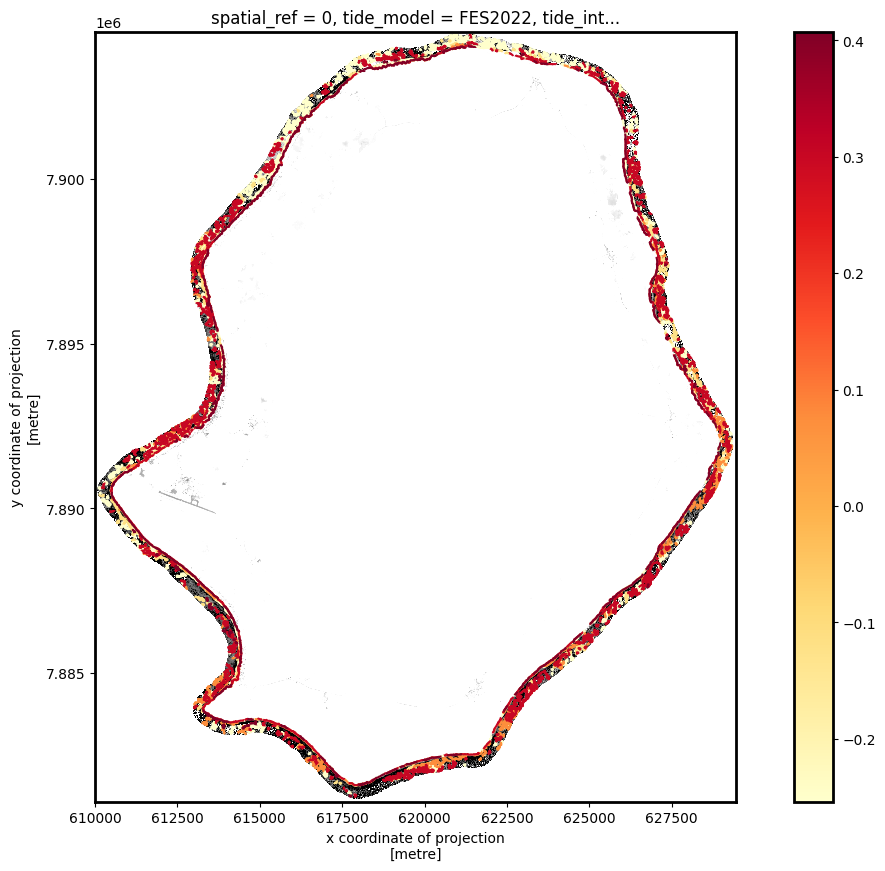

In [27]:
# Set up attributes to assign to each waterline
attribute_df = pd.DataFrame({"tide_height": ds_intervals.tide_height.values})

# Extract waterlines
contours_gdf = subpixel_contours(
    da=ds_intervals.ndwi,
    z_values=0,
    attribute_df=attribute_df,
    min_vertices=20,
    dim="tide_interval",
)

# Plot output shapefile over the top of the first tidal interval water index
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ds_intervals.ndwi.sel(tide_interval=1).plot(
    ax=ax, cmap="Greys", add_colorbar=False
)
contours_gdf.plot(ax=ax, column="tide_height", cmap="YlOrRd", legend=True);

In [28]:
#contours_gdf.explore(column="tide_height", cmap="YlOrRd")

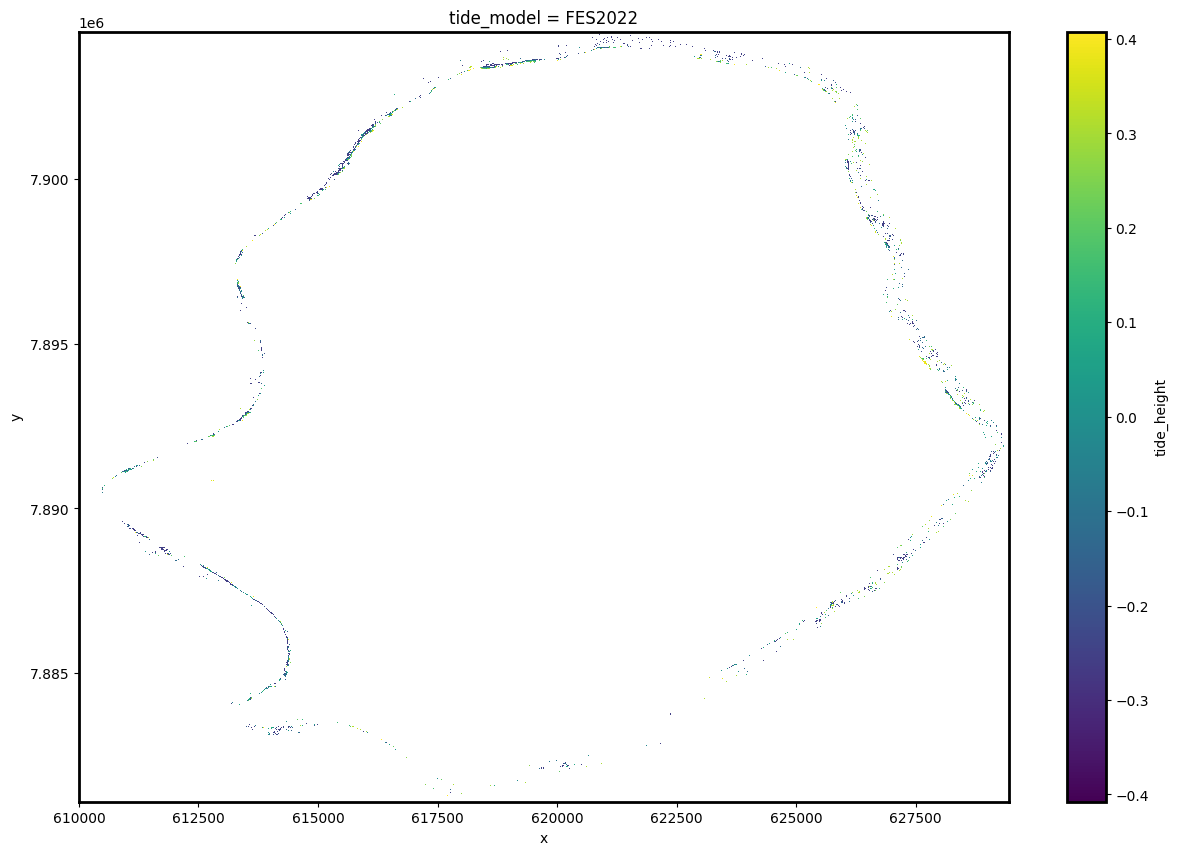

In [29]:
# Convert contour lines into point vertices for interpolation
gdf_points = extract_vertices(contours_gdf)

# Interpolate points over the spatial extent of the Landsat dataset
intertidal_dem = xr_interpolate(
    ds=ds_intervals,
    gdf=gdf_points,
).tide_height

# Identify areas that are always wet (e.g. below low tide), or always dry
above_lowest = ds_intervals.isel(tide_interval=0).ndwi < 0
below_highest = ds_intervals.isel(tide_interval=-1).ndwi > 0

# Keep only pixels between high and low tide
intertidal_dem = intertidal_dem.where(above_lowest & below_highest)

# Plot the output
intertidal_dem.plot(cmap="viridis", figsize=(15, 10))
plt.show()

In [30]:
intertidal_dem.odc.write_cog(fname=f"{country_code}_intertidal_dem.tif", overwrite=True);

### Exposure

In [31]:
#not impossible without DEM

In [32]:
client.close()